In [1]:
from Imports import *
from Plotting import *
from Helper import *
from Preprocessing import *
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jet_images_path = '../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_images_path, 'r')

print(jet_mass_data.keys())
print(jet_mass_data['image'].shape)

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


In [3]:
dev = qml.device("default.qubit", wires=8)
n_layers = 1

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 3))

@qml.qnode(dev)
def quantum_feature_embedding(f, phi, interface="torch", diff_method="backprop", cachesize=1000000):
    qml.AmplitudeEmbedding(features=f, wires=range(8), normalize=True, pad_with=0.)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(8)))

    # Measurement producing classical output values
    return qml.state()
    # return [qml.expval(qml.PauliZ(j)) for j in range(4)]

state = quantum_feature_embedding(f=[1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4], phi=rand_params)
print(state.shape)

def quantum_feature_embedding_batch(x_batch, phi, device="cuda"):
    """
    Applies quantum_feature_embedding_single to a batch of inputs.

    Args:
        x_batch (torch.Tensor): (B, D) input batch.
        phi (np.ndarray or torch.Tensor): parameters for RandomLayers.
        device (str): Device to return output on.

    Returns:
        torch.Tensor: Output of shape (B, 2 ** n_qubits)
    """
    outputs = []
    for x in x_batch:
        result = quantum_feature_embedding(x, phi)
        result_tensor = result.real.to(device)
        outputs.append(result_tensor)

    return torch.stack(outputs)

sample = torch.randn(16, 9).to("cuda")  # Example batch
phi_tensor = torch.tensor(rand_params, dtype=torch.float32)

output = quantum_feature_embedding_batch(sample, phi_tensor)
print(output.shape)

class quantum_feature_embedding_batch(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.phi = nn.Parameter(torch.tensor(np.random.uniform(high=2 * np.pi, size=(n_layers, 3)), dtype=torch.float32))
    
    def forward(self, x_batch):
        phi = self.phi
        outputs = []
        for x in x_batch:
            result = quantum_feature_embedding(x, phi)
            result_tensor = result.real.to(device)
            outputs.append(result_tensor)
    
        return torch.stack(outputs)

(256,)
torch.Size([16, 256])


In [4]:
# Generator with Quantum Layer
class Generator(nn.Module):
    def __init__(self, latent_dim=9):
        super().__init__()

        self.noise = GaussianNoise(sigma=0.3)
        
        self.feature_gen = quantum_feature_embedding_batch()

        self.image_gen1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 1x1 → 2x2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x2 → 4x4
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 4x4 → 8x8
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 8x8 → 16x16
            nn.Sigmoid()
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat).float()
        # print(img.shape)
        img = img.view(-1, 256, 1, 1)
        # print(img.shape)
        img = self.image_gen1(img)
        # print(img.shape)
        img = self.image_gen2(img)
        # print(img.shape)
        img = self.image_gen3(img)
        # print(img.shape)
        img = self.image_gen4(img)
        # print(img.shape)
        img = soft_threshold(img, threshold=0.001, sharpness=1000.0)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
                # Flattened image: 16x16 = 256
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 16, 16)
            flat_dim = self.image_encoder(dummy).shape[1] + 64

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
   
    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

Image shape: torch.Size([872, 16, 16])
dR Mean: torch.Size([872])
dR STD: torch.Size([872])
Pixel Mean: torch.Size([872])
Pixel STD: torch.Size([872])
ΔR min: 0.0
ΔR max: 2.299955368041992
ΔR mean min: 0.006367172580212355
ΔR mean max: 0.015238014049828053
ΔR std min: 0.031942661851644516
ΔR std max: 0.15263450145721436
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.003762117587029934
Pixel mean max: 0.005017686635255814
Pixel std min: 0.014734980650246143
Pixel std max: 0.06261435151100159


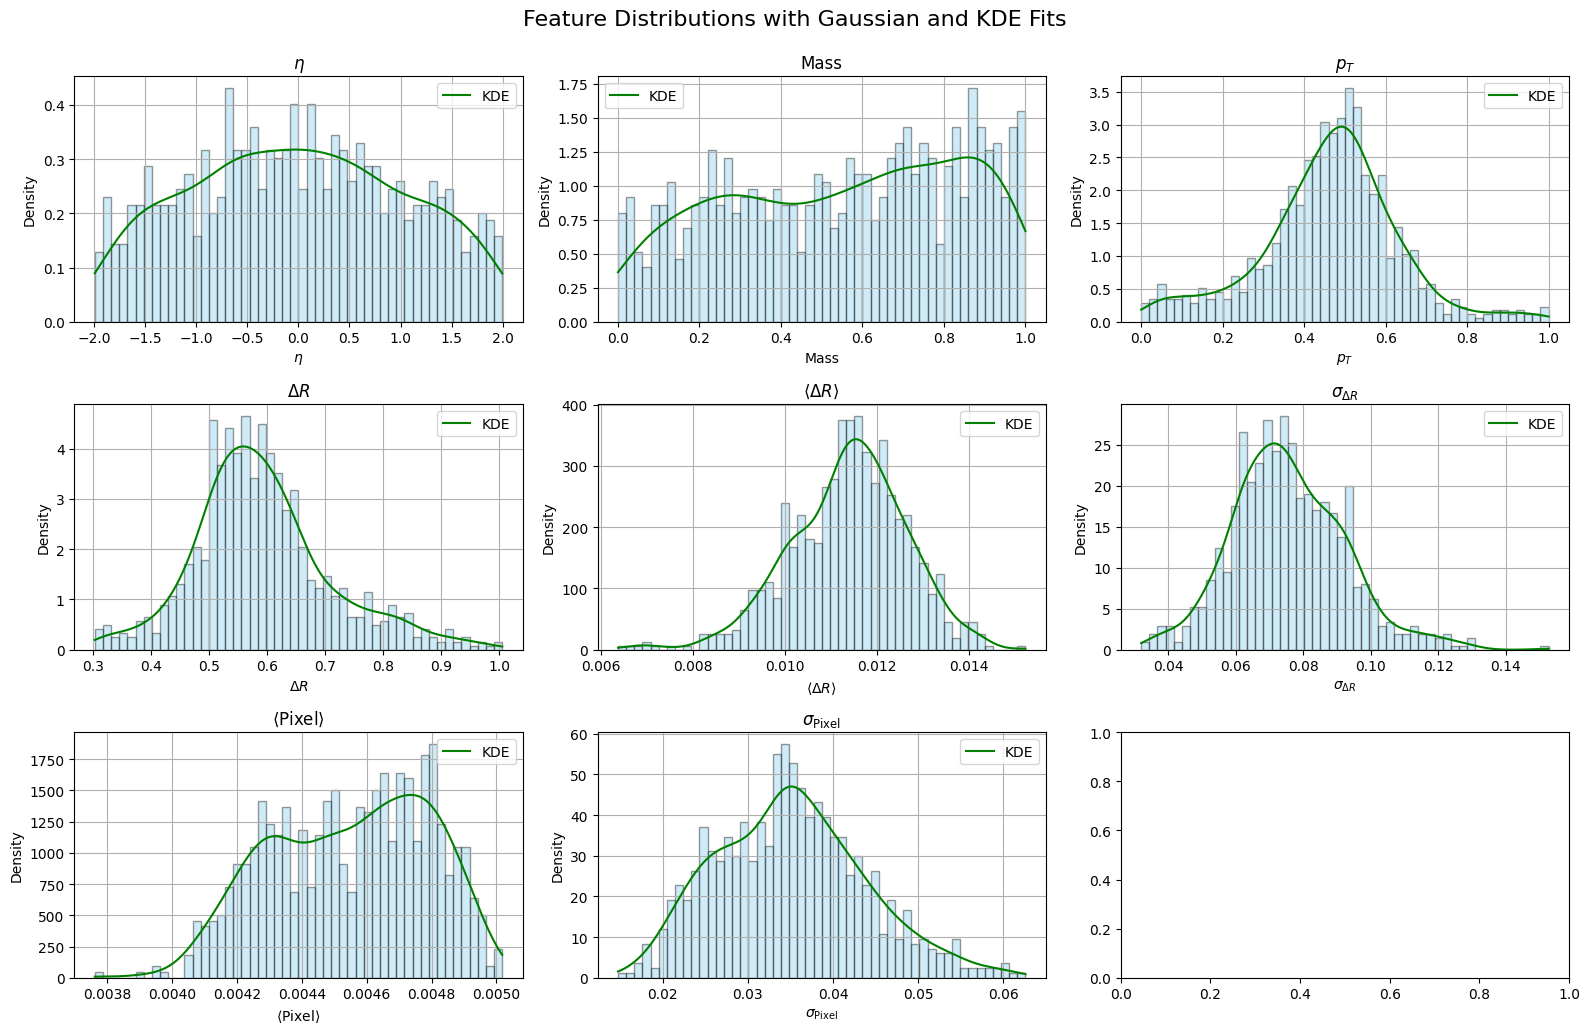

Number of samples: 872
Image shape: torch.Size([872, 16, 16])
Feature shape: torch.Size([872, 9])


In [5]:
batch_size = 128
n_events = int(.001 * jet_mass_data['image'].shape[0])

dataset = JetDataset(jet_mass_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

kdes = feature_distributions(dataset)

print("Number of samples:", len(dataset))
print("Image shape:", dataset.images.shape)
print("Feature shape:", dataset.features.shape)

In [ ]:
latent_dim = 256
lr = 10e-4
n_epochs = 300
num = 4

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

g_losses = []
d_losses = []

# Image shape: (16, 16)
H, W = (16, 16)
center_x, center_y = (W - 1) / 2, (H - 1) / 2

# Coordinate grid
x_coords, y_coords = torch.meshgrid(
    torch.arange(W, dtype=torch.float32),
    torch.arange(H, dtype=torch.float32),
    indexing='ij')

# Distance from center
dists = (torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)).cuda()
dists = dists.unsqueeze(0)  # [1, 16, 16]

tracked_fake_dR_mean = []
tracked_fake_dR_std = []
tracked_fake_pixel_mean = []
tracked_fake_pixel_std = []

tracked_real_dR_mean = []
tracked_real_dR_std = []
tracked_real_pixel_mean = []
tracked_real_pixel_std = []

In [ ]:
## Load a previous model
# Replace with the desired filename
load_path = "models/Q_gan_model_20250712_224355.pt"

# Load the checkpoint
checkpoint = torch.load(load_path)

# Restore model weights
generator.load_state_dict(checkpoint["generator_state_dict"])
discriminator.load_state_dict(checkpoint["discriminator_state_dict"])

# Optionally restore tracking data
g_losses = checkpoint["g_losses"]
d_losses = checkpoint["d_losses"]

tracked_fake_dR_mean = checkpoint["tracked_fake_dR_mean"]
tracked_fake_dR_std = checkpoint["tracked_fake_dR_std"]
tracked_fake_pixel_mean = checkpoint["tracked_fake_pixel_mean"]
tracked_fake_pixel_std = checkpoint["tracked_fake_pixel_std"]

tracked_real_dR_mean = checkpoint["tracked_real_dR_mean"]
tracked_real_dR_std = checkpoint["tracked_real_dR_std"]
tracked_real_pixel_mean = checkpoint["tracked_real_pixel_mean"]
tracked_real_pixel_std = checkpoint["tracked_real_pixel_std"]

print(f"Loaded model from {load_path}")

[Epoch 1/30] [D loss: 0.6751] [G loss: 0.8558] [Validity_loss: 0.0805] 
 [Stat_loss: 0.5181] [NNZ_loss: 0.1572]
Sample feature coding: [ 0.         -0.0902134   0.21949883  0.30551204  0.34068775  0.01159558
  0.07926971  0.00436007  0.04126468]


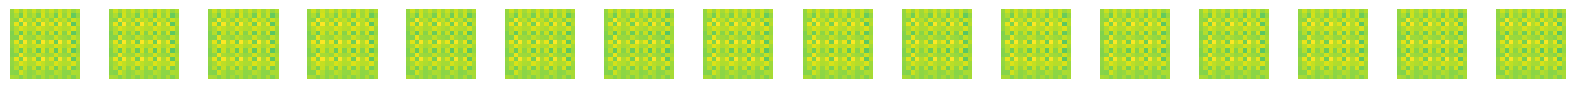

[Epoch 2/30] [D loss: 0.6133] [G loss: 0.6973] [Validity_loss: 0.1105] 
 [Stat_loss: 0.3304] [NNZ_loss: 0.1565]
Sample feature coding: [1.         0.05403192 0.81442267 0.37895018 0.5496024  0.00970573
 0.06515072 0.00431311 0.03432075]


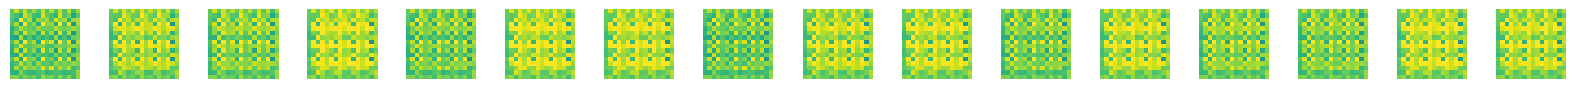

[Epoch 3/30] [D loss: 0.5085] [G loss: 0.7260] [Validity_loss: 0.1867] 
 [Stat_loss: 0.2822] [NNZ_loss: 0.1571]
Sample feature coding: [ 0.         -0.8142702   0.5156299   0.34396014  0.6486158   0.01133673
  0.07770006  0.00438951  0.0347622 ]


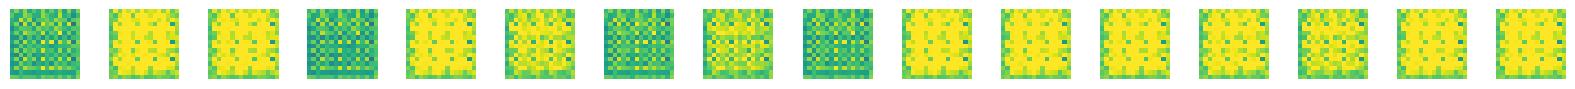

[Epoch 4/30] [D loss: 0.4294] [G loss: 0.7884] [Validity_loss: 0.3296] 
 [Stat_loss: 0.2023] [NNZ_loss: 0.1565]
Sample feature coding: [ 1.         -1.8945028   0.7898093   0.3592325   0.5455729   0.01119136
  0.0645105   0.00466009  0.04400977]


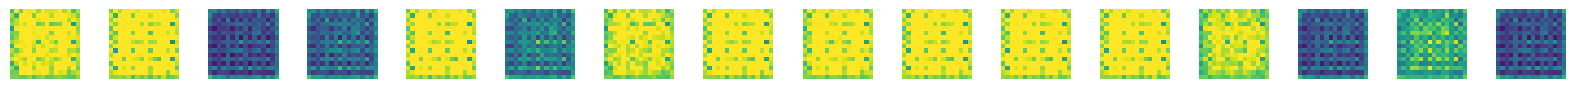

[Epoch 5/30] [D loss: 0.3952] [G loss: 0.8688] [Validity_loss: 0.4494] 
 [Stat_loss: 0.1638] [NNZ_loss: 0.1557]
Sample feature coding: [ 1.         -1.274441    0.04210661  0.18719922  0.6516671   0.0093076
  0.07546264  0.00445216  0.03487338]


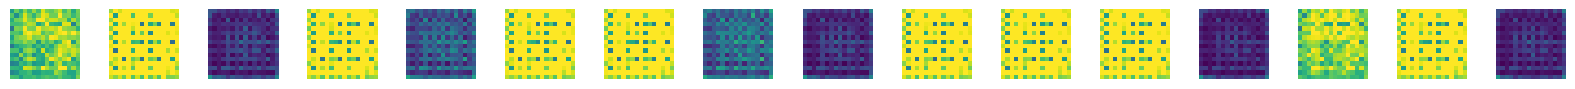

[Epoch 6/30] [D loss: 0.3711] [G loss: 0.9595] [Validity_loss: 0.5386] 
 [Stat_loss: 0.1648] [NNZ_loss: 0.1560]
Sample feature coding: [1.         0.5620475  0.85639054 0.58769464 0.8323073  0.01194498
 0.04676272 0.0050664  0.03531466]


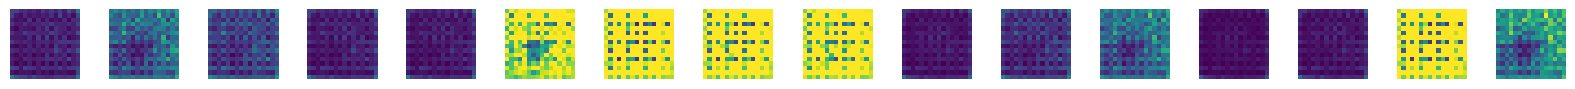

[Epoch 7/30] [D loss: 0.3438] [G loss: 0.9855] [Validity_loss: 0.5587] 
 [Stat_loss: 0.1694] [NNZ_loss: 0.1573]
Sample feature coding: [1.         1.3232518  0.88706857 0.31032833 0.3962115  0.01103431
 0.07069595 0.00446557 0.03322884]


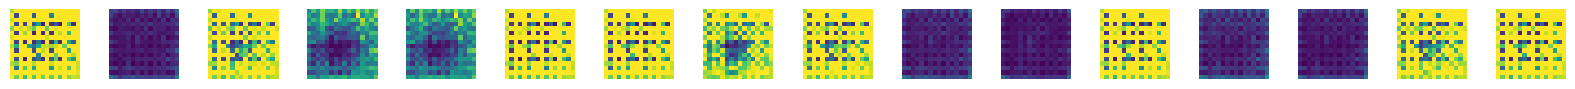

[Epoch 8/30] [D loss: 0.3122] [G loss: 0.9808] [Validity_loss: 0.5480] 
 [Stat_loss: 0.1764] [NNZ_loss: 0.1564]
Sample feature coding: [0.         0.01072594 0.01071609 0.6208895  0.6856903  0.01130877
 0.08583529 0.0043488  0.03467673]


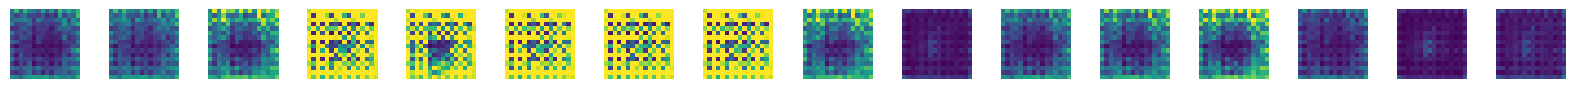

[Epoch 9/30] [D loss: 0.2807] [G loss: 0.9458] [Validity_loss: 0.5350] 
 [Stat_loss: 0.1549] [NNZ_loss: 0.1559]
Sample feature coding: [1.         0.13217188 0.08207882 0.77877945 0.6752215  0.01248212
 0.09005461 0.0045673  0.03492386]


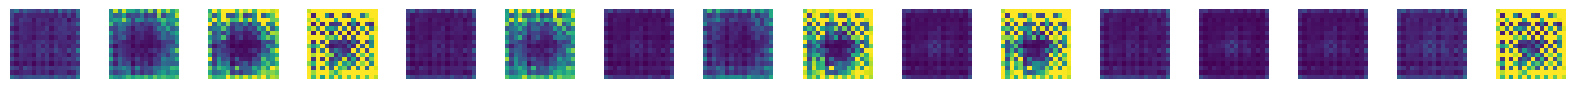

[Epoch 10/30] [D loss: 0.2503] [G loss: 0.9193] [Validity_loss: 0.5163] 
 [Stat_loss: 0.1460] [NNZ_loss: 0.1571]
Sample feature coding: [ 0.         -1.0964136   0.69510514  0.32025996  0.64557064  0.00974078
  0.08905477  0.00429464  0.03298691]


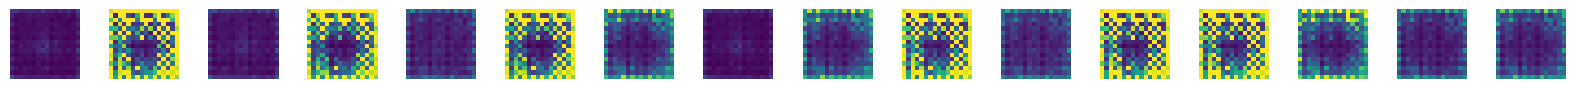

[Epoch 11/30] [D loss: 0.2211] [G loss: 0.8614] [Validity_loss: 0.4732] 
 [Stat_loss: 0.1308] [NNZ_loss: 0.1574]
Sample feature coding: [ 1.         -1.6472937   0.30456322  0.6262196   0.5916045   0.01069036
  0.05438462  0.00494885  0.03829866]


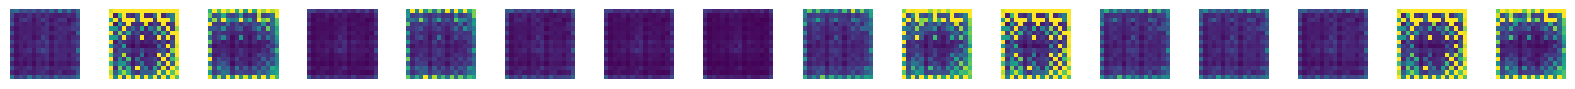

[Epoch 12/30] [D loss: 0.1891] [G loss: 0.8074] [Validity_loss: 0.4392] 
 [Stat_loss: 0.1092] [NNZ_loss: 0.1589]
Sample feature coding: [ 1.         -1.4695098   0.79070324  0.62648135  0.5771291   0.01085045
  0.09043233  0.00448187  0.02716298]


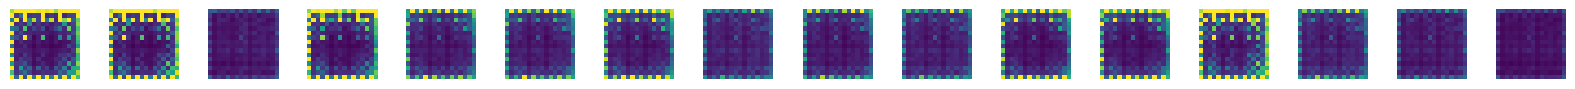

[Epoch 13/30] [D loss: 0.1679] [G loss: 0.7319] [Validity_loss: 0.3812] 
 [Stat_loss: 0.0944] [NNZ_loss: 0.1564]
Sample feature coding: [0.         0.2842443  0.838113   0.1371336  0.6468046  0.01036865
 0.06495416 0.00485312 0.03491935]


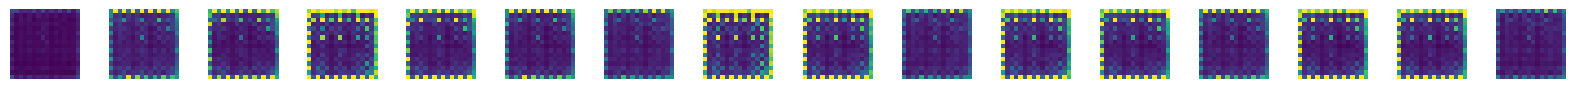

[Epoch 14/30] [D loss: 0.1389] [G loss: 0.6992] [Validity_loss: 0.3645] 
 [Stat_loss: 0.0762] [NNZ_loss: 0.1585]
Sample feature coding: [ 0.         -0.34635687  0.8134197   0.62076294  0.62489206  0.01100668
  0.05790448  0.00458048  0.04300623]


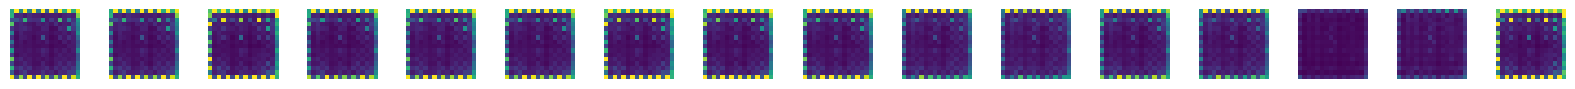

[Epoch 15/30] [D loss: 0.1185] [G loss: 0.6600] [Validity_loss: 0.3529] 
 [Stat_loss: 0.0494] [NNZ_loss: 0.1577]
Sample feature coding: [ 0.         -1.7809768   0.21375376  0.3355023   0.55906296  0.01228368
  0.07707734  0.00406041  0.01239589]


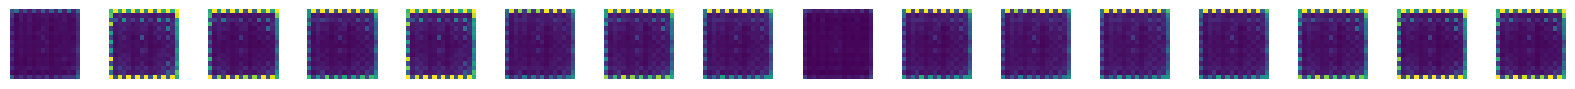

[Epoch 16/30] [D loss: 0.0998] [G loss: 0.6203] [Validity_loss: 0.3119] 
 [Stat_loss: 0.0495] [NNZ_loss: 0.1589]
Sample feature coding: [1.         0.7018378  0.6420188  0.90492374 0.4869373  0.01176939
 0.08265947 0.00454938 0.02758314]


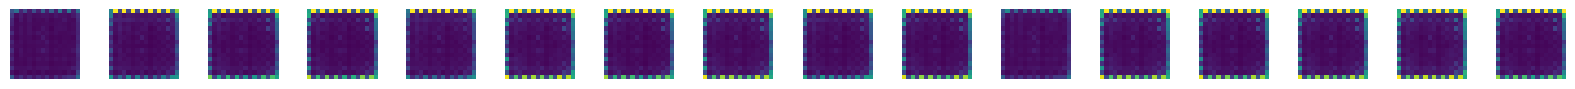

[Epoch 17/30] [D loss: 0.0905] [G loss: 0.6167] [Validity_loss: 0.3235] 
 [Stat_loss: 0.0372] [NNZ_loss: 0.1561]
Sample feature coding: [ 1.         -1.3026986   0.7275856   0.6493202   0.6179629   0.01029183
  0.04981948  0.00458703  0.02958328]


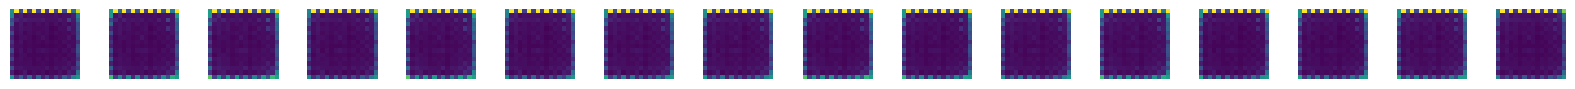

[Epoch 18/30] [D loss: 0.0784] [G loss: 0.6022] [Validity_loss: 0.3151] 
 [Stat_loss: 0.0318] [NNZ_loss: 0.1552]
Sample feature coding: [ 1.         -1.560485    0.9583024   0.87961614  0.65866506  0.01101696
  0.06529084  0.00464154  0.05087884]


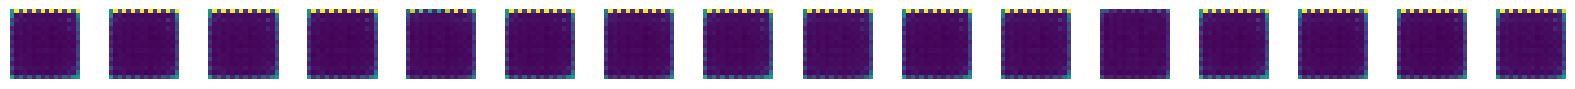

[Epoch 19/30] [D loss: 0.0768] [G loss: 0.5852] [Validity_loss: 0.3009] 
 [Stat_loss: 0.0266] [NNZ_loss: 0.1577]
Sample feature coding: [ 0.         -0.6126098   0.8603541   0.6365592   0.39616114  0.01163546
  0.05436673  0.00441618  0.05471371]


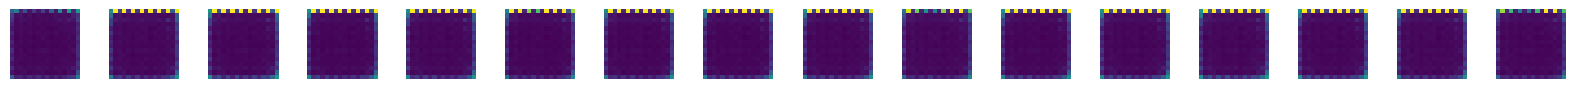

[Epoch 20/30] [D loss: 0.0865] [G loss: 0.5536] [Validity_loss: 0.2767] 
 [Stat_loss: 0.0202] [NNZ_loss: 0.1566]
Sample feature coding: [0.         0.25655934 0.29627278 0.5927452  0.527966   0.01105082
 0.0591212  0.00460509 0.0354311 ]


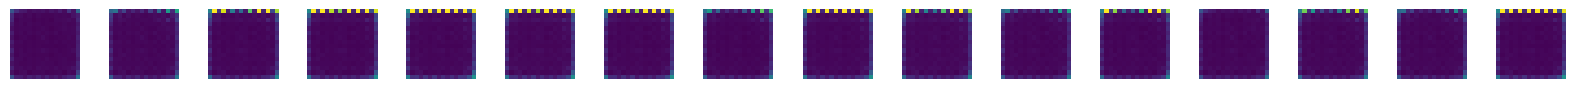

[Epoch 21/30] [D loss: 0.1320] [G loss: 0.5280] [Validity_loss: 0.2563] 
 [Stat_loss: 0.0142] [NNZ_loss: 0.1575]
Sample feature coding: [ 1.         -0.29578254  0.36267957  0.45327374  0.5610228   0.0123466
  0.07476126  0.00509205  0.05087029]


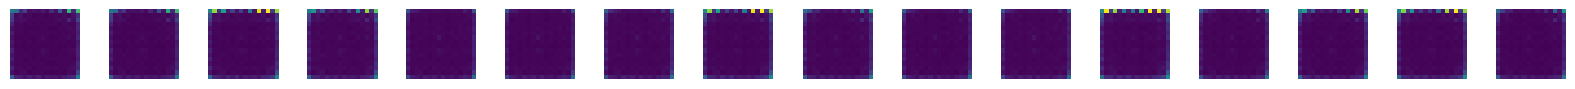

[Epoch 22/30] [D loss: 0.1580] [G loss: 0.5042] [Validity_loss: 0.2407] 
 [Stat_loss: 0.0090] [NNZ_loss: 0.1545]
Sample feature coding: [0.         0.5420287  1.0236322  0.7059029  0.90228856 0.00906197
 0.06254547 0.00478946 0.03968504]


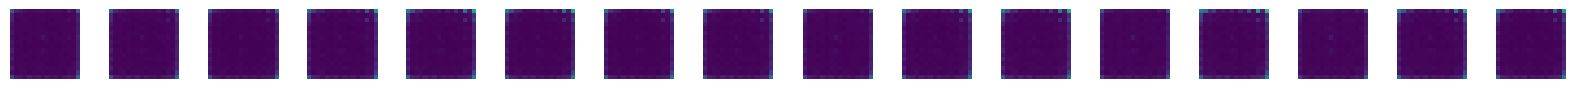

[Epoch 23/30] [D loss: 0.1604] [G loss: 0.4858] [Validity_loss: 0.2241] 
 [Stat_loss: 0.0044] [NNZ_loss: 0.1573]
Sample feature coding: [ 1.         -0.69193804  0.15951817  0.09211858  0.60878074  0.01094818
  0.07922126  0.00471161  0.0296029 ]


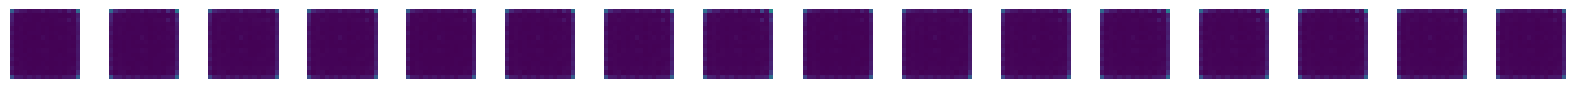

[Epoch 24/30] [D loss: 0.1974] [G loss: 0.4849] [Validity_loss: 0.2250] 
 [Stat_loss: 0.0022] [NNZ_loss: 0.1576]
Sample feature coding: [ 0.         -0.32313135  0.07854907  0.5600658   0.63284653  0.01196621
  0.05355518  0.00468257  0.03600948]


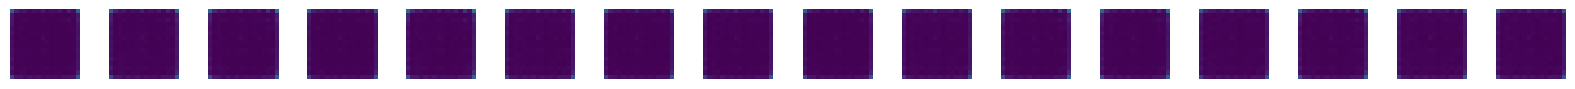

[Epoch 25/30] [D loss: 0.1905] [G loss: 0.4644] [Validity_loss: 0.2081] 
 [Stat_loss: 0.0011] [NNZ_loss: 0.1553]
Sample feature coding: [1.         0.14827725 0.8106038  0.5566544  0.51451236 0.00938116
 0.087391   0.0047794  0.02164761]


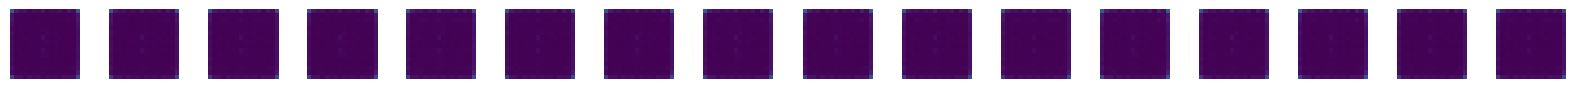

[Epoch 26/30] [D loss: 0.1791] [G loss: 0.4378] [Validity_loss: 0.1883] 
 [Stat_loss: 0.0007] [NNZ_loss: 0.1488]
Sample feature coding: [ 0.         -1.9399213   0.4994961   0.40192667  0.6304283   0.01088414
  0.07173016  0.00452219  0.02783739]


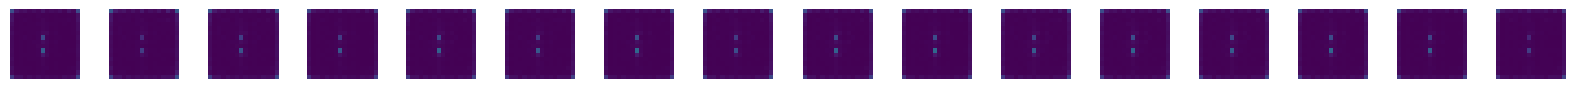

[Epoch 27/30] [D loss: 1.1075] [G loss: 0.3895] [Validity_loss: 0.1467] 
 [Stat_loss: 0.0006] [NNZ_loss: 0.1423]
Sample feature coding: [0.         0.7661163  0.97931933 0.50995004 0.5958567  0.00995062
 0.08331349 0.00428394 0.04808104]


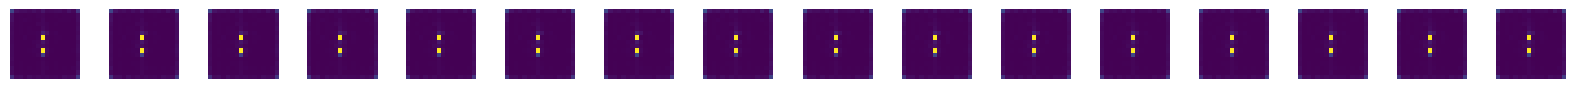

[Epoch 28/30] [D loss: 0.6907] [G loss: 0.8190] [Validity_loss: 0.5828] 
 [Stat_loss: 0.0005] [NNZ_loss: 0.1356]
Sample feature coding: [ 1.         -0.07626066  0.6541635   0.5141191   0.54973453  0.01253238
  0.08741135  0.00408926  0.02504502]


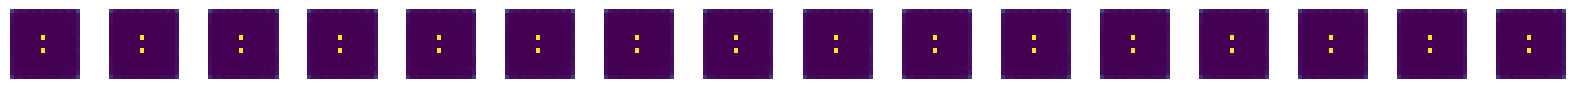

[Epoch 29/30] [D loss: 1.0523] [G loss: 0.6503] [Validity_loss: 0.4264] 
 [Stat_loss: 0.0003] [NNZ_loss: 0.1237]
Sample feature coding: [1.         0.09443032 0.91796964 0.454307   0.7331498  0.0131794
 0.04148692 0.00439295 0.0326326 ]


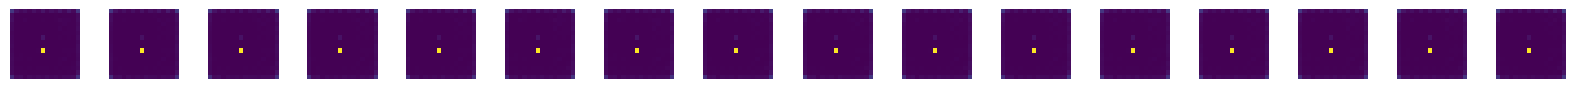

[Epoch 30/30] [D loss: 0.6680] [G loss: 0.4074] [Validity_loss: 0.1865] 
 [Stat_loss: 0.0001] [NNZ_loss: 0.1207]
Sample feature coding: [ 1.         -1.2934408   0.20946224  0.49414662  0.52046806  0.01275688
  0.06459531  0.00450623  0.02702973]


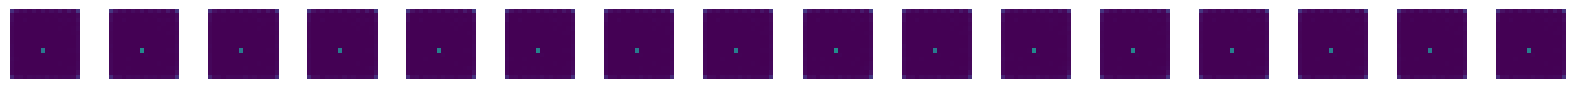

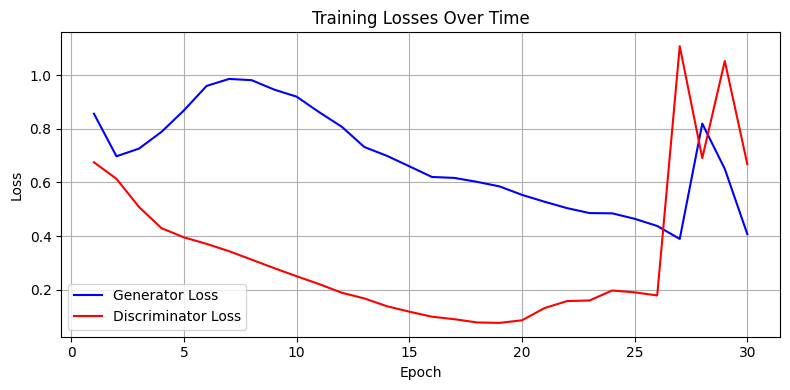

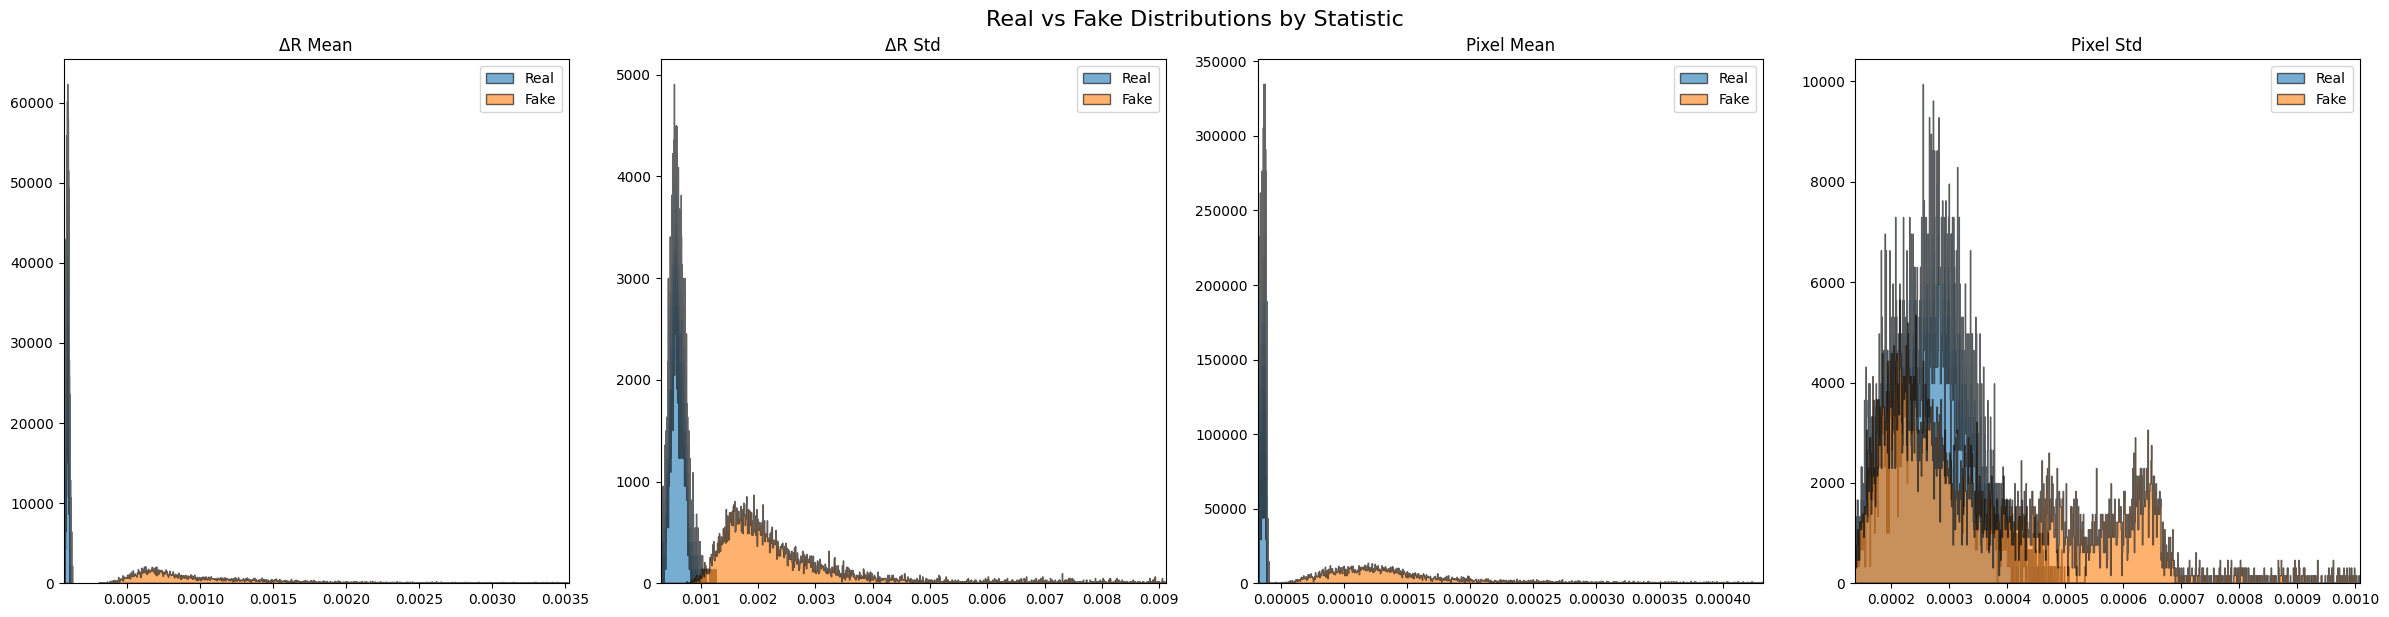

In [6]:
for epoch in range(n_epochs):
    for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
        
        # All real data are normalized in the dataloader
        real_feat = real_features.cuda()
        real_flipped_feat = flipped_features.cuda()
        real_img = real_image.unsqueeze(1).cuda()
        real_flipped_img = flipped_image.unsqueeze(1).cuda()

        # print(f"Real: {real_img.shape}")

        # Codings should be label, eta, pT, mass that get passed directly to the discriminator
        # Other values are pure noise and get passed to the generator, then those outputs passed to the discriminator

        # Discriminator training
        if i % 3 == 0:
            optimizer_D.zero_grad()
            discriminator.train()
            # Generate fake samples
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)
            # print(f"Fake: {fake_img.shape}")

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            real_disc_codings = real_feat[:,:num]
            real_flipped_disc_codings = real_flipped_feat[:,:num]
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]

            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            fake_pred = discriminator(fake_img, fake_disc_codings)
            fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)

            preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)


            # real_labels = torch.empty_like(real_pred).uniform_(0.7, 1.2)
            # fake_labels = torch.empty_like(fake_pred).uniform_(0.0, 0.3)
            # labels = (torch.cat([real_labels, fake_labels], dim=0)).cuda()

            ones = torch.ones(2*len(fake_pred))
            zeros = torch.zeros(2*len(real_pred))
            labels = (torch.cat([ones, zeros], dim=0)).cuda()

            # Discriminator loss is just its ability to distinguish
            d_loss = torch.nn.BCELoss()(preds, labels)

            d_loss.backward()
            optimizer_D.step()

        # Generator Training
        if i % 1 == 0:
            optimizer_G.zero_grad()
            # generator.train()
            
            # Generate fake data
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]
            
            # Fooled discriminator loss
            d_out = discriminator(fake_img, fake_disc_codings)
            d_out_flip = discriminator(fake_flipped_img, fake_flipped_disc_codings)
            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            
            target = torch.ones_like(d_out)
            bce = nn.BCELoss()
            validity_loss = bce(d_out, target) + bce(d_out_flip, target)
            
            # ----- Fake ΔR Calculation -----
            # Original
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_img.squeeze(1)

            dR = (weights * dists)

            fake_dR_mean = dR.mean(dim = (1,2))
            fake_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            fake_pixel_mean = weights.mean(dim = (1,2))
            fake_pixel_std = weights.std(dim = (1,2))
            
            # Flipped
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_flipped_img.squeeze(1)
            dR = (weights * dists)

            flipped_dR_mean = dR.mean(dim = (1,2))
            flipped_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            flipped_pixel_mean = weights.squeeze(1).mean(dim = (1,2))
            flipped_pixel_std = weights.squeeze(1).std(dim = (1,2))

            real_dR_mean = z_codings[:,5]
            real_dR_std = z_codings[:,6]
            real_pixel_mean = z_codings[:,7]
            real_pixel_std = z_codings[:,8]


            # Statistical MSE loss
            # dR_mean_loss = (torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) + torch.nn.MSELoss()(flipped_dR_mean, real_dR_mean))
            # dR_std_loss = (torch.nn.MSELoss()(fake_dR_std, real_dR_std) + torch.nn.MSELoss()(flipped_dR_std, real_dR_std))
            # pixel_mean_loss = (torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) + torch.nn.MSELoss()(flipped_pixel_mean, real_pixel_mean))
            # pixel_std_loss = (torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) + torch.nn.MSELoss()(flipped_pixel_std, real_pixel_std))
            
            # stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss

            # print(dR_mean_loss)
            # print(dR_std_loss)
            # print(3*pixel_mean_loss)
            # print(2*pixel_std_loss)

            # Statistical KL Divergence loss
            kl_total = 0
            kl_total += kde_kl_divergence_torch(real_dR_mean, fake_dR_mean) / .001
            kl_total += kde_kl_divergence_torch(real_dR_std, fake_dR_std) / .03
            kl_total += kde_kl_divergence_torch(real_pixel_mean, fake_pixel_mean) / .0001
            kl_total += kde_kl_divergence_torch(real_pixel_std, fake_pixel_std) / .01

            stat_loss = kl_total

            # Number non-zero loss
            fake_nnz = soft_count_nonzero(fake_img, threshold=3e-5, sharpness=10000.0)
            real_nnz = soft_count_nonzero(real_img, threshold=3e-5, sharpness=10000.0)
            nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)

            
            # Total generator loss is the average of the discriminator's predictions of the original and flipped data
            # + the difference between input and output dR and pixel statistics

            alpha = .05
            beta = .00001
            chi = .00001

            g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss) + .1

            g_loss.backward()
            optimizer_G.step()

            if n_epochs - epoch <= 10:
                # Track fake stats
                tracked_fake_dR_mean.append(fake_dR_mean.detach().cpu())
                tracked_fake_dR_std.append(fake_dR_std.detach().cpu())
                tracked_fake_pixel_mean.append(fake_pixel_mean.detach().cpu())
                tracked_fake_pixel_std.append(fake_pixel_std.detach().cpu())
                
                # Track real stats from z_codings
                tracked_real_dR_mean.append(z_codings[:,5].detach().cpu())
                tracked_real_dR_std.append(z_codings[:,6].detach().cpu())
                tracked_real_pixel_mean.append(z_codings[:,7].detach().cpu())
                tracked_real_pixel_std.append(z_codings[:,8].detach().cpu())

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[epoch]:.4f}] [G loss: {g_losses[epoch]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] \n [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 

    z_img = torch.randn(batch_size, 256, 1, 1).cuda()

    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat1 = torch.cat([z_codings, z_noise], dim=1)
    z_feat = torch.cat([z_codings], dim=1)

    fake_images = generator(z_feat)
    fake_feat = z_codings
    fake_images.detach().cpu()
    fake_feat.detach().cpu()
    # real_images = next(iter(dataloader))[0][:1000].cpu()

    # output_image = fake_images[:16]  # Save 16 generated samples
    # output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    # grid = (torchvision.utils.make_grid(output_image, nrow=4, normalize=True)).cpu()
    # np_img = grid.permute(1, 2, 0).numpy()
    # plt.imsave(f'classical_Jet_image_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, dataset, kdes, batch_size=16, latent_dim=256)

plot_metrics(g_losses, d_losses)

## Last 10 epochs stats
# Flatten all batches
fake_dR_mean_vals = torch.cat(tracked_fake_dR_mean).numpy() / batch_size
fake_dR_std_vals = torch.cat(tracked_fake_dR_std).numpy() / batch_size
fake_pixel_mean_vals = torch.cat(tracked_fake_pixel_mean).numpy() / batch_size
fake_pixel_std_vals = torch.cat(tracked_fake_pixel_std).numpy() / batch_size

real_dR_mean_vals = torch.cat(tracked_real_dR_mean).numpy() / batch_size
real_dR_std_vals = torch.cat(tracked_real_dR_std).numpy() / batch_size
real_pixel_mean_vals = torch.cat(tracked_real_pixel_mean).numpy() / batch_size
real_pixel_std_vals = torch.cat(tracked_real_pixel_std).numpy() / batch_size

fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # 4 stats

stat_titles = ['ΔR Mean', 'ΔR Std', 'Pixel Mean', 'Pixel Std']
real_stats = [real_dR_mean_vals, real_dR_std_vals, real_pixel_mean_vals, real_pixel_std_vals]
fake_stats = [fake_dR_mean_vals, fake_dR_std_vals, fake_pixel_mean_vals, fake_pixel_std_vals]

for row in range(4):
    ax = axs[row]

    real_vals = real_stats[row]
    fake_vals = fake_stats[row]

    # Compute limits
    lower = min(np.percentile(real_vals, 1), np.percentile(fake_vals, 1))
    upper = max(np.percentile(real_vals, 99), np.percentile(fake_vals, 99))

    # Truncate values
    real_vals_trunc = real_vals[(real_vals >= lower) & (real_vals <= upper)]
    fake_vals_trunc = fake_vals[(fake_vals >= lower) & (fake_vals <= upper)]

    # Plot
    ax.hist(real_vals_trunc, bins=1000, alpha=0.6, label='Real',
            edgecolor='black', density=True, histtype='stepfilled')
    ax.hist(fake_vals_trunc, bins=1000, alpha=0.6, label='Fake',
            edgecolor='black', density=True, histtype='stepfilled')

    ax.set_xlim(lower, upper)
    ax.set_title(f"{stat_titles[row]}")
    ax.legend()

plt.tight_layout()
plt.suptitle("Real vs Fake Distributions by Statistic", fontsize=16, y=1.02)
plt.show()


In [ ]:
## Save Model
# Create output directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Timestamp for unique filenames
timestamp = datetime.now().strftime("m%d_%H%M)

# Save model states and tracked data in a single file
save_path = f"models/Q_gan_short_model_{timestamp}.pt"
torch.save({
    "generator_state_dict": generator.state_dict(),
    "discriminator_state_dict": discriminator.state_dict(),
    "g_losses": g_losses,
    "d_losses": d_losses,
    "tracked_fake_dR_mean": tracked_fake_dR_mean,
    "tracked_fake_dR_std": tracked_fake_dR_std,
    "tracked_fake_pixel_mean": tracked_fake_pixel_mean,
    "tracked_fake_pixel_std": tracked_fake_pixel_std,
    "tracked_real_dR_mean": tracked_real_dR_mean,
    "tracked_real_dR_std": tracked_real_dR_std,
    "tracked_real_pixel_mean": tracked_real_pixel_mean,
    "tracked_real_pixel_std": tracked_real_pixel_std
}, save_path)

print(f"Model and statistics saved to {save_path}")

![image.png](attachment:7aee3b98-579c-4bcb-9682-eb417b7e3a7a.png)

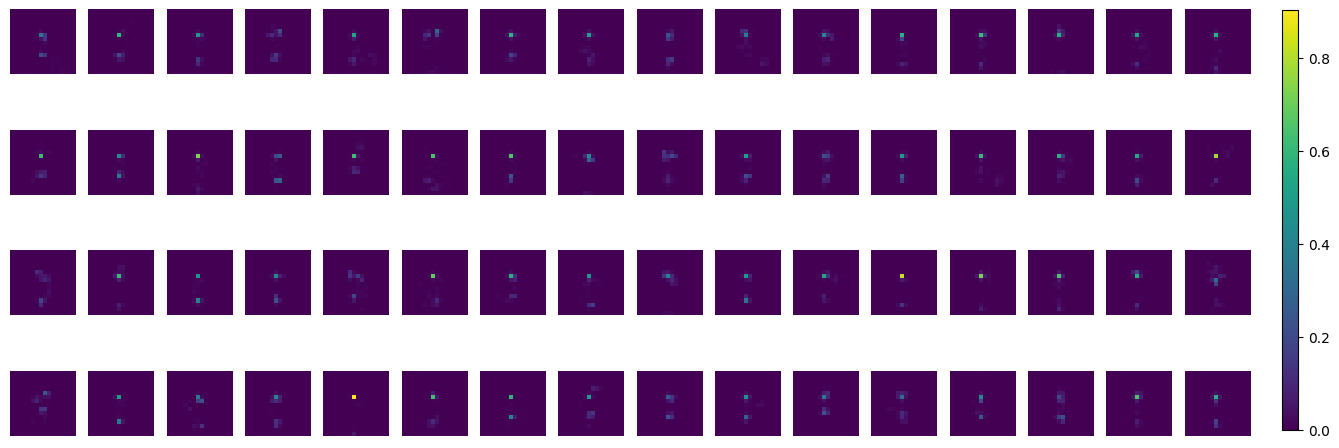

In [7]:
n_rows, n_cols = 4, 16
n_images = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 1.5))

vmin = dataset.images[:n_images].min()
vmax = dataset.images[:n_images].max()

# Show images and keep the first imshow object for colorbar
im = None
for i in range(n_images):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(dataset.images[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.axis('off')

# Add a single colorbar on the right of the grid
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

Sample feature coding: [ 0.         -0.35668772  0.900566    0.4069313   0.7170394   0.01164164
  0.07908675  0.00473732  0.03658444]


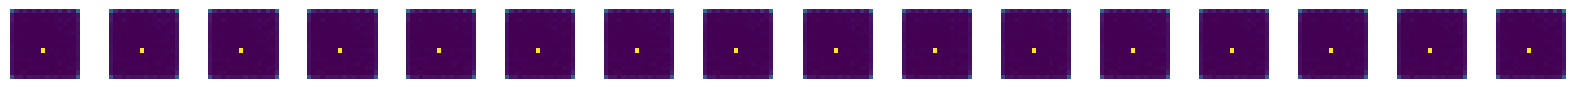

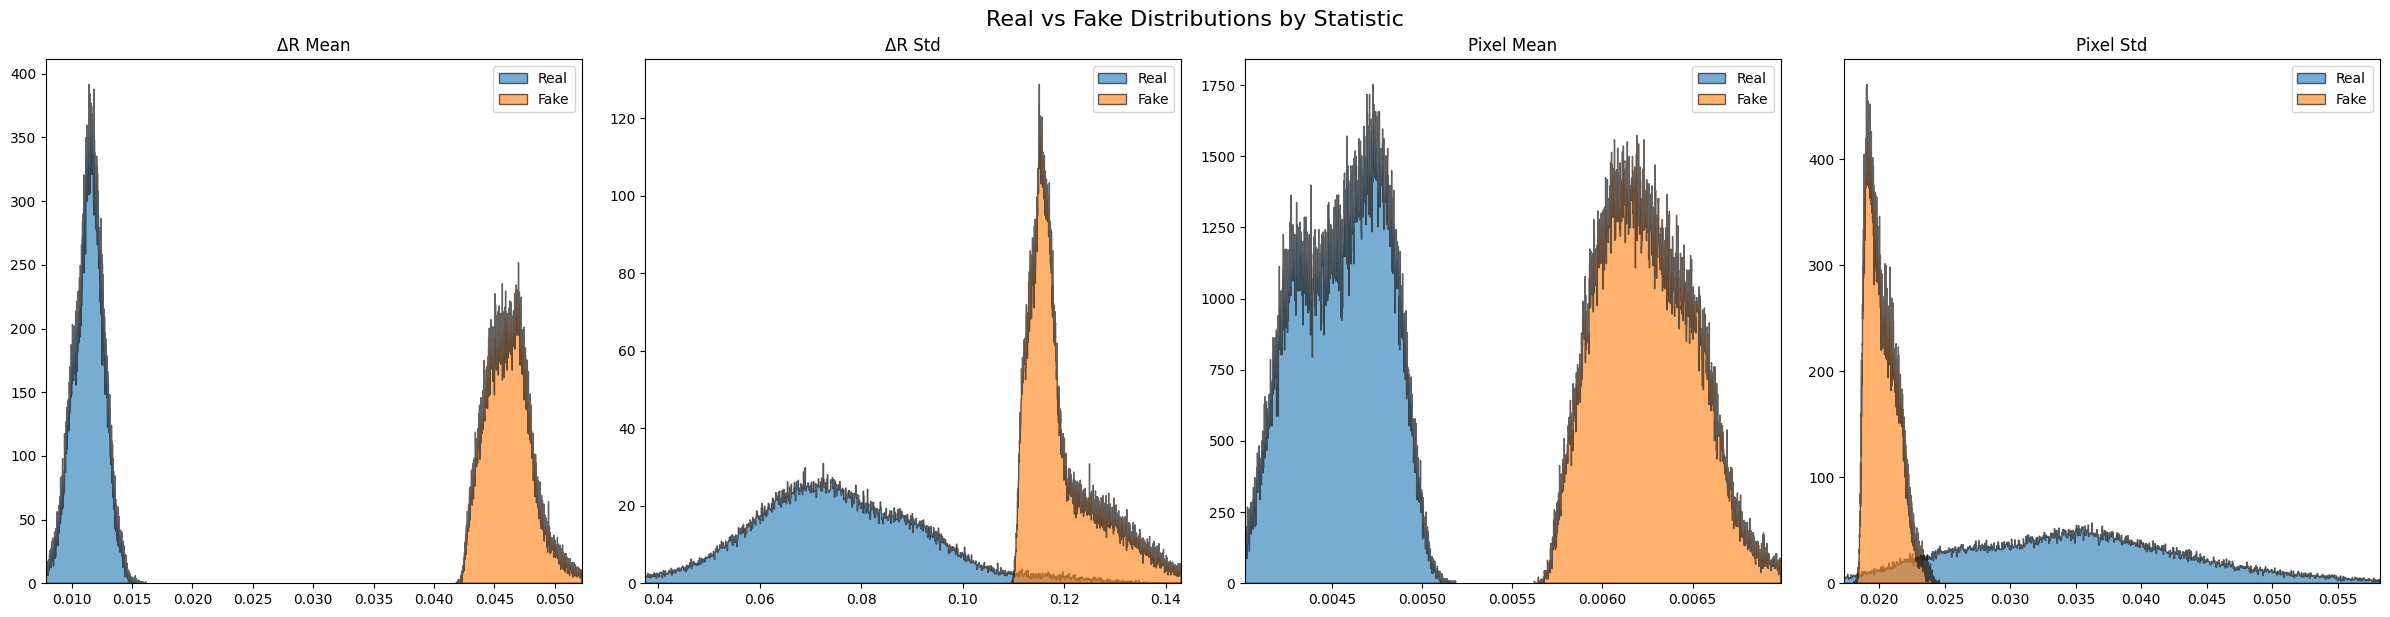

Discriminator output (wrong label): [0.26728007 0.22631055 0.18420772 0.12985693 0.21748616 0.1380064
 0.24717647 0.1728836  0.29440612 0.27026471 0.24894097 0.11000443
 0.19190425 0.1395367  0.18472478 0.1388167 ]
Discriminator output (correct label): [0.6359899  0.57642025 0.5364257  0.40102294 0.5634291  0.39041463
 0.6015273  0.5094759  0.65919757 0.63713914 0.6175014  0.41828042
 0.5432377  0.46904406 0.51774013 0.40656424]
Real labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Swapped labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Relative change (%): [614.16223 518.09204 601.2485  487.1638  494.86823 385.09836 511.1925
 604.27203 481.2028  478.15646 604.81274 789.26794 645.98834 703.9693
 527.07965 423.49512]


In [9]:
test_generated_samples(generator, discriminator, dataset, kdes, batch_size=100000)

# Optional args:
#     generator,
#     discriminator,
#     dataset,
#     kdes,
#     batch_size=16,
#     latent_dim=256,
#     codings=None,
#     plot_distributions=True,
#     compare_discriminator=True